# PROJECT CAP (Crime Analysis & Prediction)

**Author: Frank Serafine**  
[GitHub](https://github.com/fserafine) | [LinkedIn](https://www.linkedin.com/in/frankserafine/) | [Tableau Public](https://public.tableau.com/app/profile/frank.serafine)

---

## GOAL

Model time series data to predict crime activity over a split of years, given years of history, in order to establish a predictable "expected" crime level that is responsive to seasonal trends. From this, abnormalities can be classified and contextualized through supporting visualization.

**BUSINESS USE CASE:** This is a way for journalistic outlets and citizens alike to interact with crime information normally taken for granted or only intuited, providing an answer for whether or not a given time frame's actual crime levels are abnormal. 

**PROJECT DATA SOURCE:** FBI's [Crime Data Explorer](https://crime-data-explorer.fr.cloud.gov/pages/downloads)  

**NEXT STEPS ENABLED BY THIS PROJECT:** A formal ETL pipeline can be established for loading, cleaning, and analyzing US NIBRS crime data as it is released by the FBI each year. The data can then be continuously loaded into a Tableau dashboard where users can interact with it for various purposes. The FBI already has [a robust dashboard](https://crime-data-explorer.fr.cloud.gov/pages/explorer/crime/crime-trend) for examining this data, but has no machine learning estimates for any period of time.

In [1]:
# Essential packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objs as go
import statsmodels.api as sm
from statsmodels.api import tsa
import sqlite3

---  
### Section 1 - Connect, Load, and Clean Data

As explained on GitHub, this notebook requires a database be downloaded and put into the same directory as this notebook. Prior to importing the data in this notebook, I performed a fair amount of preprocessing to standardize and group the data, with the intent on having this final table as an easy-to-digest ml-ready dataset.  

Below, I establish the connection to the database and load the table that is needed. 

In [2]:
conn = sqlite3.connect('Crime_Pred.db')
df = pd.read_sql_query("SELECT * FROM crimepred_ftworth", conn)
df.head(10)

,Incident ID,Offense ID,Victim ID,Offender ID,Date,Hour,Offense,Attempted or Completed,Offender Age,Offender Gender,Offender Race,Offender Ethnicity,Offender Bias,Weapon,Victim Type,Relation to Offender,Victim Age,Victim Gender,Victim Race,Victim Ethnicity
0,52733347,60395148,57121930,59380715,2010-01-01,6.0,Theft From Building,C,56,F,Black or African American,Unknown,None,None,Business,Not Applicable,None,U,Not Applicable,Not Applicable
1,52733347,60395148,57121930,59380716,2010-01-01,6.0,Theft From Building,C,29,F,Black or African American,Unknown,None,None,Business,Not Applicable,None,U,Not Applicable,Not Applicable
2,52733379,60395154,57122868,59382318,2010-01-06,15.0,Intimidation,C,17,M,Black or African American,Unknown,None,None,Individual,Victim Was Acquaintance,66,M,White,Hispanic or Latino
3,52708159,60350552,57094869,59349493,2010-01-01,8.0,All Other Larceny,C,26,M,White,Unknown,None,None,Business,Not Applicable,None,U,Not Applicable,Not Applicable
4,52708159,60350552,57094869,59349494,2010-01-01,8.0,All Other Larceny,C,25,M,Unknown,Unknown,None,None,Business,Not Applicable,None,U,Not Applicable,Not Applicable
5,52679447,60328223,57063604,59313200,2010-01-26,8.0,All Other Larceny,C,27,F,Black or African American,Unknown,None,None,Individual,Relationship Unknown,40,F,White,Not Hispanic or Latino
6,52679447,60328223,57063604,59313201,2010-01-26,8.0,All Other Larceny,C,None,U,Unknown,Unknown,None,None,Individual,Relationship Unknown,40,F,White,Not Hispanic or Latino
7,52679447,60328223,57063604,59313202,2010-01-26,8.0,All Other Larceny,C,30,F,Black or African American,Unknown,None,None,Individual,Relationship Unknown,40,F,White,Not Hispanic or Latino
8,52730425,60393613,57118674,59376984,2010-01-04,8.0,Impersonation,C,63,F,White,Unknown,None,None,Individual,Relationship Unknown,65,M,White,Not Hispanic or Latino
9,52669952,60315146,57053237,59302243,2010-01-29,12.0,Simple Assault,C,14,M,White,Unknown,None,Personal Weapons,Individual,Relationship Unknown,35,M,Black or African American,Not Hispanic or Latino


In [3]:
# Percentage of total observations that are null:

df.isna().sum()/df.shape[0]*100

Incident ID                0.000000
Offense ID                 0.000000
Victim ID                  0.000000
Offender ID                0.000000
Date                       0.000000
Hour                       9.667328
Offense                    0.000000
Attempted or Completed     0.000000
Offender Age              37.023032
Offender Gender            0.000000
Offender Race              0.000000
Offender Ethnicity         0.000000
Offender Bias              0.000000
Weapon                     0.000000
Victim Type                0.000000
Relation to Offender       0.000000
Victim Age                25.419555
Victim Gender              0.000000
Victim Race                0.000000
Victim Ethnicity           0.000000
dtype: float64

As the above null percentages show, there are significant gaps in the FBI's knowledge of `Hour`, `Offender Age`, and `Victim Age`, although these unknowns/nulls do not always indicate a lack of information. Crimes _against an institution_ or _against society_ do not have a specific victim and thus a victim age is not applicable in those cases.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446532 entries, 0 to 1446531
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Incident ID             1446532 non-null  int64  
 1   Offense ID              1446532 non-null  int64  
 2   Victim ID               1446532 non-null  int64  
 3   Offender ID             1446532 non-null  int64  
 4   Date                    1446532 non-null  object 
 5   Hour                    1306691 non-null  float64
 6   Offense                 1446532 non-null  object 
 7   Attempted or Completed  1446532 non-null  object 
 8   Offender Age            910982 non-null   object 
 9   Offender Gender         1446532 non-null  object 
 10  Offender Race           1446532 non-null  object 
 11  Offender Ethnicity      1446532 non-null  object 
 12  Offender Bias           1446532 non-null  object 
 13  Weapon                  1446532 non-null  object 
 14  Vi

In [5]:
# Convert the Date field into a proper datetime dtype:

df['Date'] = pd.to_datetime(df['Date']) 

In [6]:
# Check for and inspect subset of duplicated data:

dupe_data = df.duplicated(keep=False)
df.loc[dupe_data, :]

,Incident ID,Offense ID,Victim ID,Offender ID,Date,Hour,Offense,Attempted or Completed,Offender Age,Offender Gender,Offender Race,Offender Ethnicity,Offender Bias,Weapon,Victim Type,Relation to Offender,Victim Age,Victim Gender,Victim Race,Victim Ethnicity
78,52832367,60249865,57230463,59503835,2010-01-08,2.0,Robbery,C,None,M,Unknown,Unknown,None,Firearm,Individual,Relationship Unknown,29,F,White,Hispanic or Latino
79,52832367,60249865,57230463,59503835,2010-01-08,2.0,Robbery,C,None,M,Unknown,Unknown,None,Firearm,Individual,Relationship Unknown,29,F,White,Hispanic or Latino
80,52832367,60249865,57230463,59503836,2010-01-08,2.0,Robbery,C,None,M,White,Unknown,None,Firearm,Individual,Relationship Unknown,29,F,White,Hispanic or Latino
81,52832367,60249865,57230463,59503836,2010-01-08,2.0,Robbery,C,None,M,White,Unknown,None,Firearm,Individual,Relationship Unknown,29,F,White,Hispanic or Latino
267,55046396,60055208,59664084,62028386,2010-01-17,4.0,Aggravated Assault,C,21,M,White,Unknown,None,Motor Vehicle,Individual,Relationship Unknown,24,M,White,Not Hispanic or Latino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446436,122902133,148693741,134884640,139754909,2019-11-15,20.0,Simple Assault,C,51,M,White,Hispanic or Latino,None,Personal Weapons,Individual,Victim Was Acquaintance,51,M,White,Hispanic or Latino
1446479,122898448,148690731,134882322,139765617,2019-12-15,4.0,Aggravated Assault,C,18,M,White,Hispanic or Latino,None,Handgun,Individual,Relationship Unknown,30,M,White,Hispanic or Latino
1446480,122898448,148690731,134882322,139765618,2019-12-15,4.0,Aggravated Assault,C,None,M,White,Hispanic or Latino,None,Handgun,Individual,Relationship Unknown,30,M,White,Hispanic or Latino
1446481,122898448,148690731,134882322,139765617,2019-12-15,4.0,Aggravated Assault,C,18,M,White,Hispanic or Latino,None,Handgun,Individual,Relationship Unknown,30,M,White,Hispanic or Latino


In [7]:
# Remove duplicate rows:

df = df.drop_duplicates(keep='first')

In [8]:
df.nunique()

Incident ID               567859
Offense ID                604731
Victim ID                 636934
Offender ID               701796
Date                        3652
Hour                          24
Offense                       51
Attempted or Completed         2
Offender Age                  98
Offender Gender                3
Offender Race                  7
Offender Ethnicity             3
Offender Bias                 19
Weapon                        22
Victim Type                    9
Relation to Offender          27
Victim Age                    98
Victim Gender                  4
Victim Race                    8
Victim Ethnicity               4
dtype: int64

In [9]:
# Sort the data by Date:

df.sort_values(by = 'Date', inplace = True)

---  
### Section 2 - Data Dictionary  

|      **Feature**       |           **Purpose**         |
|------------------------|:------------------------------|
| **Incident ID**            | Represents a single incident in NIBRS.                                                                     |
| **Offense ID**             | Represents a single criminal offense. Up to 10 offenses can be tied to a single incident.                  |
| **Victim ID**              | Represents a single victim of an incident. Up to 999 victims can be tied to a single incident.             |
| **Offender ID**            | Represents a single offender of an incident. Up to 99 offenders can be tied to a single incident.          |
| **Date**                   | The date on which an incident occurred.                                                                    |
| **Hour**                   | The hour in which an incident occurred or started, in 24-hr format.                                                         |
| **Offense**                | The criminal offense classification logged for a given Offense ID in NIBRS.                                |
| **Attempted or Completed** | Denotes whether an action that constituted a criminal offense was attempted or actually completed.         |
| **Offender Age**           | The age of the indicated offender, if known.                                                               |
| **Offender Gender**        | The gender (Male, Female, or Unknown) of the indicated offender.                                           |
| **Offender Race**          | The race of the indicated offender, if known.                                                              |
| **Offender Ethnicity**     | The ethnicity of the indicated offender, if known.                                                         |
| **Offender Bias**          | The specific bias of the indicated offender, if applicable.                                                |
| **Weapon**                 | The specific weapon or class of weapon alleged to have been used by the indicated offender, if applicable. |
| **Victim Type**            | The main broad classification of a victim of an incident.                                                  |
| **Relation to Offender**   | The relationship of the victim to the indicated offender, if applicable.                                   |
| **Victim Age**             | The age of the indicated victim, if known and applicable.                                                  |
| **Victim Gender**          | The gender (Male, Female, Not Applicable, or Unknown) of the indicated victim.                             |
| **Victim Race**            | The race of the indicated victim, if known and applicable.                                                 |
| **Victim Ethnicity**       | The ethnicity of the indicated victim, if known and applicable.



This final dataset contains ___567,859 incidents___ from which ___604,731 criminal offenses___ were recorded, with ___701,796 offenders___ acting either individually or in concert to commit ___51 types of offenses___ against ___636,934 victims___ from January 1st, 2010 through December 31st, 2019.

In [10]:
# Sanity-check the data to ensure that the data is ml-ready:

df.head()

,Incident ID,Offense ID,Victim ID,Offender ID,Date,Hour,Offense,Attempted or Completed,Offender Age,Offender Gender,Offender Race,Offender Ethnicity,Offender Bias,Weapon,Victim Type,Relation to Offender,Victim Age,Victim Gender,Victim Race,Victim Ethnicity
0,52733347,60395148,57121930,59380715,2010-01-01,6.0,Theft From Building,C,56,F,Black or African American,Unknown,None,None,Business,Not Applicable,None,U,Not Applicable,Not Applicable
6053,55031909,60045125,59647305,62010310,2010-01-01,18.0,Destruction/Damage/Vandalism of Property,C,None,U,Unknown,Unknown,None,None,Individual,Relationship Unknown,42,M,White,Not Hispanic or Latino
6052,55031908,60035779,59647304,62010309,2010-01-01,17.0,All Other Larceny,C,None,M,Unknown,Unknown,None,None,Individual,Relationship Unknown,26,M,White,Not Hispanic or Latino
6051,55031907,60036418,59647303,62010308,2010-01-01,17.0,Destruction/Damage/Vandalism of Property,C,None,M,White,Unknown,None,None,Individual,Relationship Unknown,37,M,White,Not Hispanic or Latino
6050,55031906,60035778,59647302,62010307,2010-01-01,18.0,Burglary/Breaking & Entering,C,43,M,White,Unknown,None,None,Individual,Victim Was Acquaintance,36,M,White,Hispanic or Latino


In [ ]:
# Export data for Visualization in Tableau

# df.to_csv('Crime_Pred_FW_DeDuped.csv')

___Note:___ I export the data to a CSV in order to perform exploratory data analysis in Tableau because of the greatly reduced functionality available in Tableau for SQLite databases as data sources. A CSV allows full functionality.

In [11]:
# Set the date as the index of my dataframe for modeling:

df = df.set_index("Date")

In [12]:
# Binarize all non-identifier-based categorical features for aggregating:

df_dummies = pd.get_dummies(df, columns = ['Offender Ethnicity', 'Victim Ethnicity', 'Hour', 'Offense', 'Attempted or Completed', 'Offender Age', 'Offender Gender', 'Offender Race', 'Offender Bias', 'Weapon', 'Victim Type', 'Relation to Offender', 'Victim Age', 'Victim Gender', 'Victim Race'])

In [13]:
# Check the dummies to ensure successful binarization

df_dummies.head(1)

,Incident ID,Offense ID,Victim ID,Offender ID,Offender Ethnicity_Hispanic or Latino,Offender Ethnicity_Not Hispanic or Latino,Offender Ethnicity_Unknown,Victim Ethnicity_Hispanic or Latino,Victim Ethnicity_Not Applicable,Victim Ethnicity_Not Hispanic or Latino,...,Victim Gender_Not Applicable,Victim Gender_U,Victim Race_American Indian or Alaska Native,Victim Race_Asian,"Victim Race_Asian, Native Hawaiian, or Other Pacific Islander",Victim Race_Black or African American,Victim Race_Native Hawaiian or Other Pacific Islander,Victim Race_Not Applicable,Victim Race_Unknown,Victim Race_White
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,52733347,60395148,57121930,59380715,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0


In [14]:
# Take identifier columns and transform them into distinct counts:

daily_unique_counts = df_dummies.groupby(df_dummies.index).nunique()
daily_unique_counts = daily_unique_counts.filter(['Incident ID', 'Offense ID', 'Victim ID', 'Offender ID'], axis = 1)

# Take non-identifier categorical columns and transform them into binarized observations and aggregate to daily sums:

daily_sums = df_dummies.groupby(df_dummies.index).sum()
daily_sums = daily_sums.drop(columns = ['Incident ID', 'Offense ID', 'Victim ID', 'Offender ID'], axis = 1)

# Combine daily identifier unique counts and categorical daily sums into one DataFrame:

daily_totals = pd.concat([daily_unique_counts, daily_sums], axis = 1)

In [15]:
# Sanity check to ensure the daily_totals dataframe is as expected:

daily_totals.head(1)

,Incident ID,Offense ID,Victim ID,Offender ID,Offender Ethnicity_Hispanic or Latino,Offender Ethnicity_Not Hispanic or Latino,Offender Ethnicity_Unknown,Victim Ethnicity_Hispanic or Latino,Victim Ethnicity_Not Applicable,Victim Ethnicity_Not Hispanic or Latino,...,Victim Gender_Not Applicable,Victim Gender_U,Victim Race_American Indian or Alaska Native,Victim Race_Asian,"Victim Race_Asian, Native Hawaiian, or Other Pacific Islander",Victim Race_Black or African American,Victim Race_Native Hawaiian or Other Pacific Islander,Victim Race_Not Applicable,Victim Race_Unknown,Victim Race_White
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,190,204,215,254,0.0,0.0,359.0,111.0,81.0,155.0,...,0.0,81.0,1.0,0.0,3.0,61.0,0.0,81.0,1.0,212.0


---  
### Section 3 - Decomposition

For trend, season, and residual (outlier) decomposition, I focus exclusively on the `Offense ID` column, as it now totals the number of unique criminal offenses per day.  

This will serve broadly for modeling to indicate the overall level of crime on a daily basis going forward.

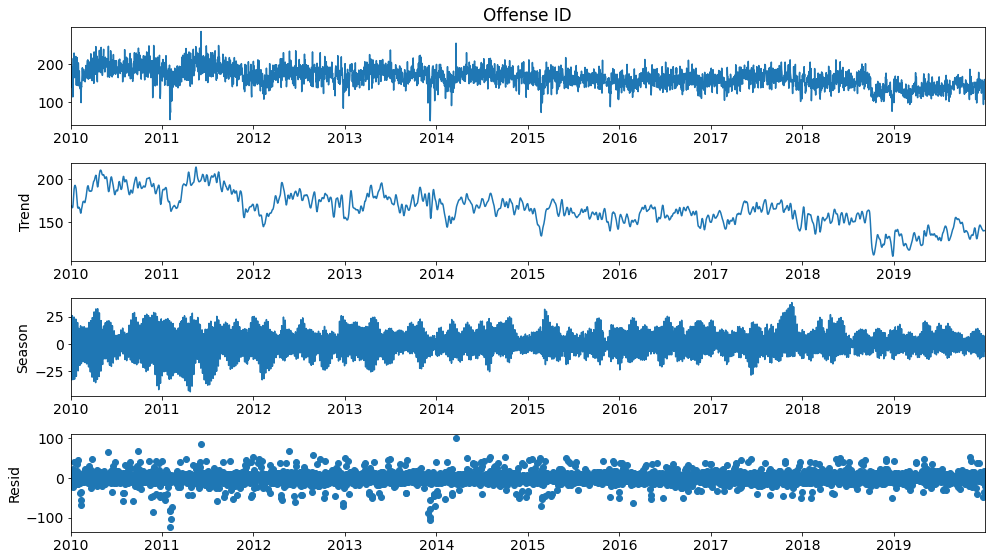

In [58]:
# Weekly seasonality STL LOESS decomposition:

from statsmodels.tsa.seasonal import STL

stl = STL(daily_totals['Offense ID'], seasonal = 7, seasonal_deg = 0, trend_deg = 0, low_pass_deg = 0, robust = True)
res = stl.fit()
plt.rc("figure", figsize = (14,8))
plt.rcParams.update({'font.size': 14})
fig = res.plot()

#### Analysis of Decomposition

**Trend**  
++++++++++

Within the trend view, we see that the highest levels of crime generally occur in the first half of each year with the exception of the last three years of the data.  

We also see a general yearly seasonality where levels fall to their lowest in February of a year, then gradually rise and peak mid-year, falling back down in February of the next year to where they were before or lower.  

Granular monthly seasonality is also shown in small peaks and troughs within each year.

Further, we clearly see an unusual reduction in crime levels in late 2018, followed by an unusual overall rise in crime levels thereafter, likely indicating highly abnormal levels of crime.
  

**Season**  
++++++++++

Monthly fluctuations are seen more smoothly generalized, with 2010-2012 marking seasons of greater variation compared with other years. We see that there is clearly never a time where crime levels remain constant for longer than a month.


**Residual**  
++++++++++

2010, 2011, and late 2013 / early 2014 show the highest deviations in crime levels, with most other years showing a fairly even occurrence and intensity of deviations in crime levels.

---  
### Section 4 - Weekly Seasonal Differences

In [17]:
# Calculate a weekly seasonal difference value:

daily_totals['Seasonal Difference'] = daily_totals['Offense ID'].diff(7)

In [19]:
# Plot the seasonal differences over time:

fig = px.line(daily_totals['Offense ID'], x = daily_totals.index, y = daily_totals['Seasonal Difference'])

fig.update_layout(
    yaxis_title="Difference in Crime Levels", 
    xaxis_title="Date",
    title="Change in Offense Counts over Prior Week")

fig.show()

#### Analysis of Weekly Differences

When the above plot is zoomed in on to show just 1-2 months of points, the weekly seasonality comes through poignantly in regular peaks and troughs showing a general resetting every 7 days. Often, the steepest drops in crime levels are spaced 5-7 days apart from each other.

Most frequently, _Thursdays_ and _Tuesdays_ indicate the highest increases in crime levels. Monthly, the highest crime upticks for a given month occur generally on the first 1-2 days of the month.

When examined without zooming, the difference levels indicate a much more reactive criminal populace in the first half of the ten-year span, showing more drastic increases and decreases and a wider spread of crime level differences overall. With the exception of late December 2019, 2015 through 2019 levels show a much lower variation in crime levels.

#### Additional Notes on Holiday Differences

Yearly, there is a consistent drastic uptick in crime levels around New Year's Day, with 2016 being the lone exception to this. Christmas and Thanksgiving both accompany a consistent drop in crime levels.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



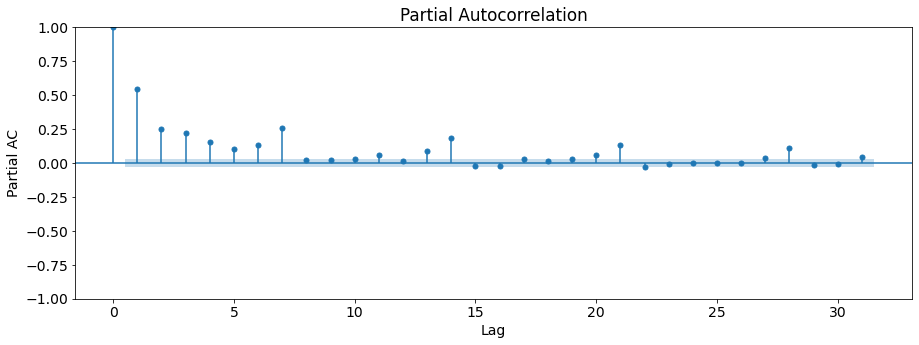

In [57]:
# Partial Autocorrelation Plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (15, 5))
plt.rcParams.update({'font.size': 14})
plot_pacf(daily_totals["Offense ID"].dropna(), lags = 31, alpha = .10, ax = plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

The above partial autocorrelation plot points to 7 lags showing the most significant autocorrelations, indicating that weekly seasonality is the best light to view this data in.

Going forward, I will use weekly seasonality in addition to daily aggregates to predict base expected crime levels for periods of time.

In [29]:
# Train/Test Split of Seasonal (7 Days) Difference in Offense Counts:

train_diff = daily_totals.loc[daily_totals.index <= '2018-01-01', 'Seasonal Difference'].dropna()
test_diff = daily_totals.loc[daily_totals.index > "2018-01-01", 'Seasonal Difference']

# Train/Test Split of Offense and Incident Totals for Multivariate Model:

train = daily_totals.loc[daily_totals.index < '2018-01-01', ['Offense ID', 'Incident ID']].dropna()
test = daily_totals.loc[daily_totals.index >= "2018-01-01", ['Offense ID', 'Incident ID']]

In [59]:
# Plot of Train/Test Split of Seasonal Difference in Offense counts:

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_diff.index, y=train_diff, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test_diff.index, y=test_diff, mode='lines', name="Test"))
fig.update_layout(
    yaxis_title="Difference in Offense Counts", 
    xaxis_title="Date",
    title="Train/Test Split of Time Series",
    yaxis = dict(tickfont = dict(size=14))
)
fig.show()

---  
### Section 5 - SARIMAX Modeling

I will now make a function that will tune the hyperparameters of the SARIMAX model, attempting to find the optimal model for my first time series predictions.

I am using the **Akaike Information Criterion** scores for each of the model attempts in order to gauge which model is the best fit for predicting Offense counts.

In [66]:
# Find the optimal Sarimax model through AIC score evaluation:

import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax(ts, all_params):
    results = []
    for param in all_params:
        try:
            mod = SARIMAX(ts,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

# Parameter Range

p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]

# All Parameter Combos

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_params = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(train['Offense ID'],all_params)

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:28510.13
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:26647.14


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 7) - AIC:26647.36
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:27691.68


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:26647.3


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 7) - AIC:26649.78


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 7) - AIC:27350.63


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 7) - AIC:26648.47


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 7) - AIC:26651.3


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:27186.43


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 7) - AIC:25383.85


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 7) - AIC:25384.83


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC:26419.77


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 7) - AIC:25384.83


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 7) - AIC:25386.83


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 7) - AIC:26131.51


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 7) - AIC:25386.82


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 7) - AIC:12.0


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:27071.12


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 2)x(0, 1, 1, 7) - AIC:25330.47


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 2)x(0, 1, 2, 7) - AIC:25332.29


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 2)x(1, 1, 0, 7) - AIC:26293.57


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 2)x(1, 1, 1, 7) - AIC:25332.29


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 2)x(1, 1, 2, 7) - AIC:25376.62


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 2)x(2, 1, 0, 7) - AIC:25990.72


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(0, 1, 2)x(2, 1, 1, 7) - AIC:25334.19


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Tried out SARIMAX(0, 1, 2)x(2, 1, 2, 7) - AIC:25336.14
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 7) - AIC:27932.44


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 7) - AIC:26041.79


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 7) - AIC:26043.44


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 7) - AIC:27088.75


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 0)x(1, 1, 1, 7) - AIC:26043.43


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 0)x(1, 1, 2, 7) - AIC:26112.09


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 0)x(2, 1, 0, 7) - AIC:26752.54


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 0)x(2, 1, 1, 7) - AIC:26044.79


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 0)x(2, 1, 2, 7) - AIC:26105.76


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 1)x(0, 1, 0, 7) - AIC:27057.16


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 1)x(0, 1, 1, 7) - AIC:25323.91


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 1)x(0, 1, 2, 7) - AIC:25325.36


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 1)x(1, 1, 0, 7) - AIC:26272.25


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 1)x(1, 1, 1, 7) - AIC:25325.35


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 1)x(1, 1, 2, 7) - AIC:25327.43


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 1)x(2, 1, 0, 7) - AIC:25965.19


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 1)x(2, 1, 1, 7) - AIC:25327.11


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(1, 1, 1)x(2, 1, 2, 7) - AIC:25456.93


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(1, 1, 2)x(0, 1, 0, 7) - AIC:27049.8


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(1, 1, 2)x(0, 1, 1, 7) - AIC:25317.9


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(1, 1, 2)x(0, 1, 2, 7) - AIC:25318.49


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(1, 1, 2)x(1, 1, 0, 7) - AIC:26395.21


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(1, 1, 2)x(1, 1, 1, 7) - AIC:25318.43


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Tried out SARIMAX(1, 1, 2)x(1, 1, 2, 7) - AIC:25321.11


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Tried out SARIMAX(1, 1, 2)x(2, 1, 0, 7) - AIC:25933.03


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Tried out SARIMAX(1, 1, 2)x(2, 1, 1, 7) - AIC:25319.52


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(1, 1, 2)x(2, 1, 2, 7) - AIC:25362.78
Tried out SARIMAX(2, 1, 0)x(0, 1, 0, 7) - AIC:27668.15


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 0)x(0, 1, 1, 7) - AIC:25786.51


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 0)x(0, 1, 2, 7) - AIC:25788.01


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 0)x(1, 1, 0, 7) - AIC:26825.88


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 0)x(1, 1, 1, 7) - AIC:25787.99


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 0)x(1, 1, 2, 7) - AIC:25854.39


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 0)x(2, 1, 0, 7) - AIC:26476.1


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 0)x(2, 1, 1, 7) - AIC:25789.24


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 0)x(2, 1, 2, 7) - AIC:25848.06


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 1)x(0, 1, 0, 7) - AIC:27051.92


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 1)x(0, 1, 1, 7) - AIC:25320.67


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 1)x(0, 1, 2, 7) - AIC:25321.65


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 1)x(1, 1, 0, 7) - AIC:26258.58


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 1)x(1, 1, 1, 7) - AIC:25321.62


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 1)x(1, 1, 2, 7) - AIC:25370.48


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 1)x(2, 1, 0, 7) - AIC:25948.15


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 1)x(2, 1, 1, 7) - AIC:25323.11


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 7) - AIC:25365.01


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 7) - AIC:27039.35


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 7) - AIC:25324.52


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 7) - AIC:25326.42


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 7) - AIC:26270.81


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No fr

Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 7) - AIC:25326.41


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 7) - AIC:25328.54


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 7) - AIC:25969.29


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 7) - AIC:25327.91


E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 7) - AIC:25360.78


In the above `all_res` SARIMAX results container, the lowest AIC score model setting was that of _25317.90_ for the settings _order = (1, 1, 2)_ and _seasonal_order = (0, 1, 1, 7)_, but the Ljung-Box score was statistically significant, indicating that its residuals are not independent/not due to chance. Therefore, I will not choose this model, but another with a similar but slightly higher score.

A more ideal setting was found at an AIC score of _25320.67_ for the settings _order = (2, 1, 1)_ and _seasonal_order = (0, 1, 1, 7)_, and the Ljung-Box score for this model indicates that the residuals are indeed independent. See this model below.

In [77]:
# SARIMAX Weekly Model using optimal settings:

p_param = 2

sari_model = SARIMAX(train["Offense ID"], order = (p_param, 1, 1), seasonal_order = (0, 1, 1, 7), trend = "c")
sari_model_fit = sari_model.fit()

sari_model_fit.summary()

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Offense ID   No. Observations:                 2922
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -12745.261
Date:                           Tue, 30 Nov 2021   AIC                          25502.521
Time:                                   22:16:53   BIC                          25538.385
Sample:                               01-01-2010   HQIC                         25515.440
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.994e-05   1.66e-05      1.202      0.229   -1.26e-05    5.25e-05
ar.L1          0.2967      0.015     19.342      0.000       0.267       0.327
ar.L2          0.1487      0.018      8.460      0.000       0.114       0.183
ma.L1         -0.9964      0.002   -600.751      0.000      -1.000      -0.993
ma.S.L7       -0.9984      0.005   -220.900      0.000      -1.007      -0.990
sigma2       367.7094      7.728     47.582      0.000     352.563     382.856
===================================================================================
Ljung-Box (L1) (Q):                   1.14   Jarque-Bera (JB):               325.87
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

I will plot the predictions below, but first I will run another SARIMAX model on the seasonal differences so that a confidence interval can be established to determine the range of crime level differences we can expect.

If a given difference level is outside the 95% confidence interval, it will indicate a period of abnormally high or low crime.

In [81]:
# SARIMAX Seasonal Difference Model

p_param = 1

sari_diff_model = SARIMAX(train_diff, order = (p_param, 1, 1), trend="c")
sari_diff_model_fit = sari_diff_model.fit()

sari_diff_model_fit.summary()

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Seasonal Difference   No. Observations:                 2916
Model:                SARIMAX(1, 1, 1)   Log Likelihood              -13533.722
Date:                 Tue, 30 Nov 2021   AIC                          27075.444
Time:                         22:31:32   BIC                          27099.354
Sample:                     01-08-2010   HQIC                         27084.057
                          - 01-01-2018                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8.617e-05      0.001     -0.142      0.887      -0.001       0.001
ar.L1          0.2089      0.015     14.214      0.000       0.180       0.238
ma.L1         -0.9999      0.040    -24.999      0.000      -1.078      -0.921
sigma2       629.4598     29.098     21.632      0.000     572.428     686.492
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               151.74
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
# Make predictions from SARIMAX Seasonal Difference model

sari_diff_predict = sari_diff_model_fit.get_prediction(start = test.index[0], end = test.index[-1])
sari_diff_confint = sari_diff_predict.conf_int()

# Make predictions from SARIMAX model

sari_predict = sari_model_fit.get_prediction(start = test.index[0], end = test.index[-1])
sari_confint = sari_predict.conf_int()

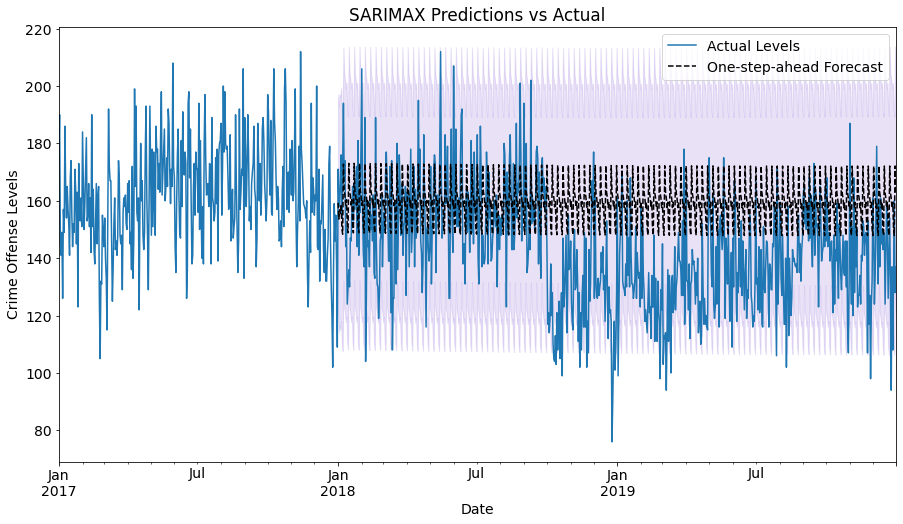

In [83]:
# Plot Actual vs SARIMAX predictions

fig, ax = plt.subplots(figsize = (15,8))
plt.rcParams.update({'font.size': 14})
npre = 4
ax.set(title = 'SARIMAX Predictions vs Actual', xlabel = "Date", ylabel = 'Crime Offense Levels')

daily_totals.loc['2017-01-01':, 'Offense ID'].plot(ax = ax, style = '-', label = 'Actual Levels')

sari_predict.predicted_mean.plot(ax = ax, style = 'k--', label = 'One-step-ahead Forecast')
ci = sari_confint
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='mediumpurple', alpha = 0.20)

legend = ax.legend(loc = 'upper right')

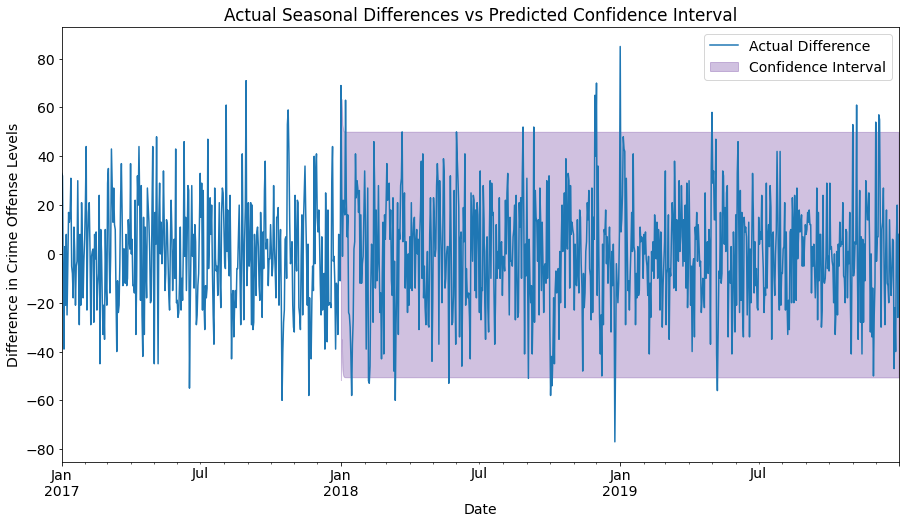

In [86]:
# Plot Actual Seasonal Differences vs SARIMAX Confidence Interval prediction

fig, ax = plt.subplots(figsize = (15,8))
plt.rcParams.update({'font.size': 14})
npre = 4
ax.set(title = 'Actual Seasonal Differences vs Predicted Confidence Interval', xlabel = "Date", ylabel = 'Difference in Crime Offense Levels')

daily_totals.loc['2017-01-01':, 'Seasonal Difference'].plot(ax = ax, style = '-', label = 'Actual Difference')

ci_diff = sari_diff_confint
ax.fill_between(ci_diff.index, ci_diff.iloc[:,0], ci_diff.iloc[:,1], color='rebeccapurple', label = 'Confidence Interval', alpha = 0.30)

legend = ax.legend(loc = 'upper right')

---  
### Section 6 - Vector Autoregressive Modeling

Because `Offense ID` and `Incident ID` are closely correlated, I am going to use a set of forecasted predictions resulting from a VAR model, as VAR models are exclusively for examining two or more correlated features in a time series.

In [96]:
# Vector Autoregressive Model (multivariate model) 

from statsmodels.tsa.api import VAR

var_model = VAR(train) 
var_results = var_model.fit(maxlags = 7, ic = 'aic', trend = 'c')
var_results.summary()

E:\Python\envs\crime_pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Nov, 2021
Time:                     22:58:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.42041
Nobs:                     2915.00    HQIC:                   8.38105
Log likelihood:          -20425.5    FPE:                    4267.96
AIC:                      8.35889    Det(Omega_mle):         4224.37
--------------------------------------------------------------------
Results for equation Offense ID
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 50.663126         4.656846           10.879           0.000
L1.Offense ID          0.256244         0.105628            2.426           0.015
L1.Incident ID        -0.024162         0.110858   

In [98]:
# Vector Autoregressive model Forecasting

var_pred = var_results.forecast(train.values, steps=len(test))

df_forecast = pd.DataFrame(var_pred, index=test.index, columns=test.columns) 
df_forecast[['Offense ID']]

,Offense ID
Date,
2018-01-01,129.435174
2018-01-02,137.848224
2018-01-03,143.672988
2018-01-04,146.057724
2018-01-05,148.655680
...,...
2019-12-27,170.829236
2019-12-28,170.829236
2019-12-29,170.829236


In [99]:
# Graph object display of SARIMAX predictions vs VAR forecast vs actual
fig = go.Figure()

# Count of Offenses - orig and forecast
fig.add_trace(go.Scatter(x = daily_totals.index[2191:], y = daily_totals['Offense ID'].iloc[2191:], mode = 'lines', name = "Actual Offense Count", line = {'color': 'darkseagreen'}))
fig.add_trace(go.Scatter(x = test.index, y = sari_predict.predicted_mean, mode = 'lines', name = 'SARIMAX Predictions', line={'dash': 'dash', 'color': 'darkviolet'}))
fig.add_trace(go.Scatter(x = test.index, y = df_forecast['Offense ID'], mode = 'lines', name = "VAR Forecast", line = {'dash': 'dash', 'color': 'blue'}))


fig.update_layout(
    yaxis_title="Counts", 
    xaxis_title="Year",
    legend_title="Actual Vs Predicted", 
    title="Forecast of Crime Counts 2018-2019 VS Actual"
)
fig.show()

In [61]:
# MAPE ANALYSIS

mape_predictions = pd.Series(data=np.full((train['Offense ID'].shape[0] + test['Offense ID'].shape[0], ), np.mean(train['Offense ID'])), index=pd.concat([train, test]).index)

from sklearn.metrics import mean_absolute_percentage_error

train_mape = mean_absolute_percentage_error(train['Offense ID'], mape_predictions[train.index])
test_mape = mean_absolute_percentage_error(test['Offense ID'], mape_predictions[test.index])

print(f"Train MAPE: {round(train_mape, 2)}%")
print(f"Test MAPE: {round(test_mape, 2)}%")

Train MAPE: 0.12%
Test MAPE: 0.24%


The MAPE score on the train set showed a very high accuracy, but performed slightly worse on the test set. When looking at the data, it is obvious to see that the massive drop in crime levels in late 2018 and the subsequent abnormal slow rise over 2019 contributed greatly to this mismatch in accuracies.

In [ ]:
# Prophet predicting setup for Offense Counts

from fbprophet import Prophet

prophet_train = daily_totals.loc[daily_totals.index < '2018-01-01', ['Offense ID']].dropna().reset_index()
prophet_train.rename(columns={'Date': 'ds', 'Offense ID': 'y'}, inplace=True)
prophet_train.head()

In [ ]:
# Fit Prophet model with daily seasonality
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.fit(prophet_train)

# Make df with future test dates
future = prophet_model.make_future_dataframe(periods=len(test), freq="D", include_history=False)
future.head()

In [ ]:
# Predict
forecast = prophet_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# Plot Prophet results

from fbprophet.plot import plot_plotly

fig = plot_plotly(prophet_model, forecast)
fig.add_trace(go.Scatter(x = daily_totals.index, 
                         y = daily_totals['Offense ID'], 
                         mode = 'lines', 
                         name = "Offense Count", 
                         line = {'color': 'dimgray'}))
fig.update_layout(
    yaxis_title = "Counts", 
    xaxis_title = "Year",
    legend_title = "Actual Vs Predicted", 
    title = "Forecast of Criminal Offenses 2010-2019 VS Actual")
fig.show()

In [ ]:
# Graph object display of SARIMAX predictions vs VAR forecast vs actual
fig = plot_plotly(prophet_model, forecast)

# Count of Offenses - orig and forecast
fig.add_trace(go.Scatter(x = daily_totals.index, y = daily_totals['Offense ID'], mode = 'lines', name = "Actual Offense Count", line = {'color': 'darkseagreen'}))
fig.add_trace(go.Scatter(x = test.index, y = sari_predict.predicted_mean, mode = 'lines', name = 'SARIMAX Predictions', line={'dash': 'dash', 'color': 'darkviolet'}))
fig.add_trace(go.Scatter(x = test.index, y = df_forecast['Offense ID'], mode = 'lines', name = "VAR Forecast", line = {'dash': 'dash', 'color': 'blue'}))


fig.update_layout(
    yaxis_title="Counts", 
    xaxis_title="Year",
    legend_title="Actual Vs Predicted", 
    title="Combined Prophet / VAR / SARIMAX Predictions of Crime Counts vs Actual"
)
fig.show()

In [ ]:
# Loop through offense type column list to generate Prophet predictions for each
offense_columns = [col for col in daily_totals if col.startswith('Offense_')]

for col in offense_columns:
    
    # Format DataFrame in the way Prophet expects
    prophet_train = daily_totals.loc[daily_totals.index < '2018-01-01', [col]].dropna().reset_index()
    prophet_train.rename(columns={'Date': 'ds', col: 'y'}, inplace=True)
    # Fit Prophet model
    model = Prophet(seasonality_mode='multiplicative')
    model.fit(prophet_train)
    
    # Make DataFrame with future test dates
    future = model.make_future_dataframe(periods=len(test), freq="D", include_history=False)
    
    # Predict
    forecast = model.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Plot Prophet results

    fig = plot_plotly(model, forecast)
    fig.add_trace(go.Scatter(x = daily_totals.index, 
                         y = daily_totals[col], 
                         mode = 'lines', 
                         name = f'{col} Counts', 
                         line = {'color': 'dimgray'}))
    fig.update_layout(
    yaxis_title = "Counts", 
    xaxis_title = "Year",
    legend_title = "Actual Vs Predicted", 
    title = f'{col} Forecast')
    fig.show()

In [ ]:
# FAILED ATTEMPT AT RNN

# from sklearn import preprocessing
# from sklearn.preprocessing import MinMaxScaler

# rnn_train = daily_totals.loc[daily_totals.index < '2018-01-01'].dropna()
# rnn_test = daily_totals.loc[daily_totals.index >= '2018-01-01'].dropna()

# sc = MinMaxScaler(feature_range = (0, 1))
# rnn_train_scaled = sc.fit_transform(rnn_train)

# # rnn_train_scaled = rnn_train_scaled.reset_index()

# rnn_X_train = []
# rnn_y_train = []
# for i in range(60, 1258):
#     rnn_X_train.append(rnn_train_scaled[i-60:i, 0])
#     rnn_y_train.append(rnn_train_scaled[i, 0])
# rnn_X_train, rnn_y_train = np.array(rnn_X_train), np.array(rnn_y_train)

In [ ]:
# FAILED ATTEMPT AT RNN

# rnn_X_train = np.reshape(rnn_X_train, (rnn_X_train.shape[0], rnn_X_train.shape[1], 1))

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout

# regressor = Sequential()

# regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (rnn_X_train.shape[1], 1)))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 100, return_sequences = False))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.2))
# regressor.add(Dense(units = 1))

# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# regressor.fit(rnn_X_train, rnn_y_train, epochs = 100, batch_size = 32)